In [16]:
from PIL import Image
import requests
import torch
from transformers import CLIPProcessor, CLIPModel
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import random
from util import *
import splice
# Path to your images
test_images_path = '../data/imagenet/val/'
import open_clip

# Load the dataset
dataset = datasets.ImageFolder(root=test_images_path)

# Create a DataLoader to load the images in batches
dataloader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=4)
random.seed(1234)

In [2]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
tokenizer = open_clip.get_tokenizer('ViT-B-32')
device = "cuda"

In [3]:
def collate_fn_whitenoise(batch):
    images = zip(*batch)  # Unpack the batch into images and labels
    # Apply the preprocess function to each image
    images = [preprocess(image) for image in images]
    # Stack the preprocessed images into a single tensor
    inputs = torch.stack(images)
    return inputs

In [4]:
all_image_features = torch.load('../computed_embeddings/image_features_vit-b-32.pt')

In [9]:
random.seed(1234)
num_samples = 20000

# Randomly select 10k indices without replacement
indices = torch.randperm(all_image_features.size(0))[:num_samples]
# Use the indices to select the corresponding rows
subsampled_image_features = all_image_features[indices]

In [10]:
k = 50
L = glaplacian(subsampled_image_features.cpu())
U, S, Vt = randomized_svd(L, n_components=k)
S_diag = np.diag(S) 
Z = U @ S_diag
Z_rotated, Rz = varimax_with_rotation(Z)
sign_Z = np.diag(np.where(np.mean(Z_rotated**3, axis=0) >= 0, 1, -1))
Z_hat = Z_rotated @ sign_Z
Y_hat = sign_Z @ Rz.T @ Vt

In [18]:

import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Move model to GPU if available
device = "cuda"
model.to(device)

# Define custom dataset for white noise images
class WhiteNoiseDataset(Dataset):
    def __init__(self, num_images, height, width, channels):
        self.num_images = num_images
        self.height = height
        self.width = width
        self.channels = channels
    
    def __len__(self):
        return self.num_images
    
    def __getitem__(self, idx):
        # Generate a single white noise image
        white_noise_image = np.random.rand(self.height, self.width, self.channels) * 255
        return torch.tensor(white_noise_image.transpose(2, 0, 1), dtype=torch.float32)  # Return tensor in channels-first format

# Set parameters for white noise images and batch size
num_images = 10000  # Adjust as needed
height, width, channels = 224, 224, 3
batch_size = 64

# Create the white noise dataset and dataloader
white_noise_dataset = WhiteNoiseDataset(num_images, height, width, channels)
dataloader = DataLoader(white_noise_dataset, batch_size=batch_size, shuffle=False, num_workers=16)

# Preallocate a tensor to store all embeddings
embedding_dim = 512  # CLIP model's embedding dimension
all_image_features = torch.empty((num_images, embedding_dim), device=device)

# Process batches of images and store embeddings in the preallocated tensor
start_idx = 0

for inputs in tqdm(dataloader):  # No need to ignore labels if none are returned
    # Move the inputs to the device (GPU)
    inputs = inputs.to(device)
    with torch.no_grad():
        image_features = model.encode_image(inputs)  # (batch_size, 512)
    # Store the batch embeddings into the preallocated tensor
    end_idx = start_idx + image_features.size(0)
    all_image_features[start_idx:end_idx] = image_features
    start_idx = end_idx

print("All image features shape:", all_image_features.shape)  # (total_num_images, 512)

100%|██████████| 157/157 [00:05<00:00, 30.59it/s]

All image features shape: torch.Size([10000, 512])


In [19]:
white_noise_image_features = all_image_features
k = 50
L = glaplacian(white_noise_image_features.cpu())
U, S, Vt = randomized_svd(L, n_components=k)
S_diag = np.diag(S) 
Z = U @ S_diag
Z_rotated, Rz = varimax_with_rotation(Z)
sign_Z = np.diag(np.where(np.mean(Z_rotated**3, axis=0) >= 0, 1, -1))
Z_hat_wn = Z_rotated @ sign_Z
Y_hat_wn = sign_Z @ Rz.T @ Vt

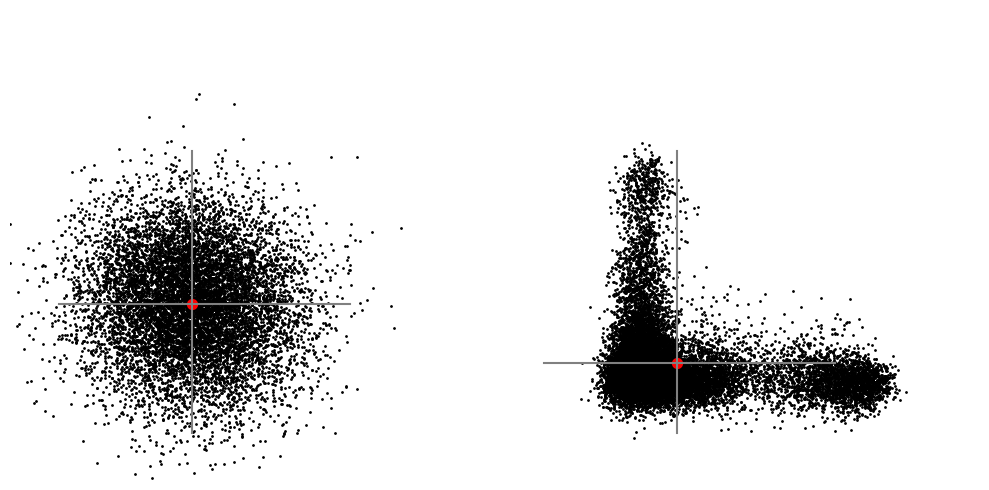

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Recenter Z_hat by subtracting the mean of columns 2 and 4
Z_hat_centered = Z_hat.copy()
Z_hat_centered[:, 2] = Z_hat[:, 2] - np.mean(Z_hat[:, 2])
Z_hat_centered[:, 4] = Z_hat[:, 4] - np.mean(Z_hat[:, 4])

# Recenter Z_hat_wn by subtracting the mean of columns 2 and 4
Z_hat_wn_centered = Z_hat_wn.copy()
Z_hat_wn_centered[:, 3] = Z_hat_wn[:, 3] - np.mean(Z_hat_wn[:, 3])
Z_hat_wn_centered[:, 2] = Z_hat_wn[:, 2] - np.mean(Z_hat_wn[:, 2])

# Create a figure and two subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))


# First scatter plot in the second subplot with centered data
ax[0].scatter(Z_hat_wn_centered[:, 3], Z_hat_wn_centered[:, 2], s=1, color='black')
# ax[0].set_title("White noise images are\n rotation-invariant.", fontsize=18)
ax[0].axhline(0, color='grey', linewidth=1.5, xmin=0.1, xmax=0.7)  # Add 0-axis line for y
ax[0].axvline(0, color='grey', linewidth=1.5, ymin=0.1, ymax=0.7)  # Add 0-axis line for x
ax[0].scatter(0, 0, color='red', s=50)  # Add red origin point
ax[0].set_xlim([-0.00015, 0.00025])
ax[0].set_ylim([-0.00015, 0.00025])

# Second scatter plot in the first subplot with centered data
ax[1].scatter(Z_hat_centered[:, 2], Z_hat_centered[:, 4], s=1, color = 'black')
# ax[1].set_title("ImageNet images have radial streaks.",fontsize=18)
ax[1].axhline(0, color='grey', linewidth=1.5,  xmin=0.1, xmax=0.7)  # Add 0-axis line for y
ax[1].axvline(0, color='grey', linewidth=1.5,  ymin=0.1, ymax=0.7)  # Add 0-axis line for x
ax[1].scatter(0, 0, color='red', s=50)  # Add red origin point
ax[1].set_xlim([-0.0015, 0.0025])
ax[1].set_ylim([-0.001, 0.003])

# Remove axis values (tick labels) for both subplots
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

for a in ax:
    for spine in ['top', 'right', 'bottom', 'left']:
        a.spines[spine].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
# Show the combined figure
plt.show()

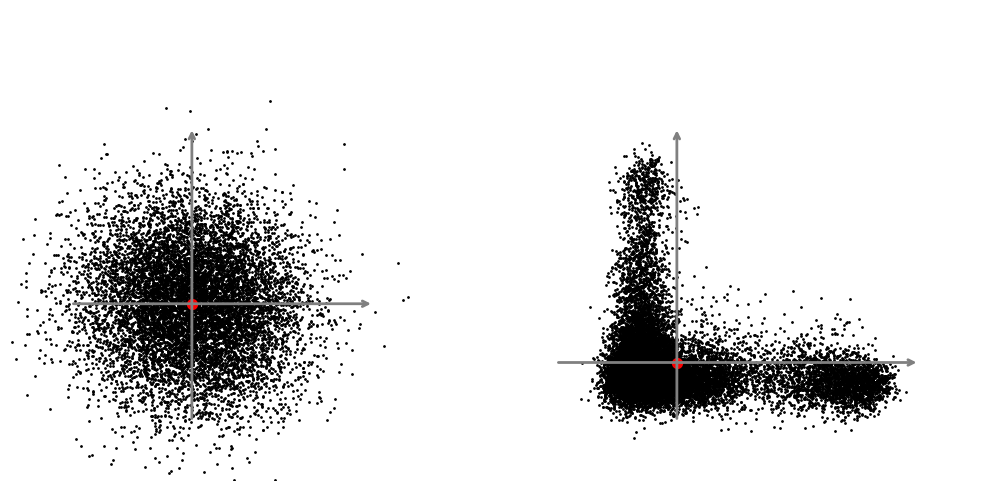

In [103]:
import matplotlib.pyplot as plt
import numpy as np

# Recenter Z_hat by subtracting the mean of columns 2 and 4
Z_hat_centered = Z_hat.copy()
Z_hat_centered[:, 2] = Z_hat[:, 2] - np.mean(Z_hat[:, 2])
Z_hat_centered[:, 4] = Z_hat[:, 4] - np.mean(Z_hat[:, 4])

# Recenter Z_hat_wn by subtracting the mean of columns 2 and 4
Z_hat_wn_centered = Z_hat_wn.copy()
Z_hat_wn_centered[:, 2] = Z_hat_wn[:, 2] - np.mean(Z_hat_wn[:, 2])
Z_hat_wn_centered[:, 3] = Z_hat_wn[:, 3] - np.mean(Z_hat_wn[:, 3])


# Create a figure and two subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# First scatter plot in the second subplot with centered data
ax[0].scatter(Z_hat_wn_centered[:, 2],Z_hat_wn_centered[:, 3], s=1, color='black')
ax[0].scatter(0, 0, color='red', s=50)  # Add red origin point
ax[0].set_xlim([-0.00015, 0.00025])
ax[0].set_ylim([-0.00015, 0.00025])

# Add arrows using annotate for the first plot
ax[0].annotate('', xy=(0.00015, 0), xytext=(-0.0001, 0),
               arrowprops=dict(arrowstyle="->", color='grey', linewidth=2))
ax[0].annotate('', xy=(0, 0.00015), xytext=(0, -0.0001),
               arrowprops=dict(arrowstyle="->", color='grey', linewidth=2))

# Second scatter plot in the first subplot with centered data
ax[1].scatter(Z_hat_centered[:, 2], Z_hat_centered[:, 4], s=1, color='black')
ax[1].scatter(0, 0, color='red', s=50)  # Add red origin point
ax[1].set_xlim([-0.0015, 0.0025])
ax[1].set_ylim([-0.001, 0.003])

# Add arrows using annotate for the second plot
ax[1].annotate('', xy=(0.002, 0), xytext=(-0.001, 0),
               arrowprops=dict(arrowstyle="->", color='grey', linewidth=2))
ax[1].annotate('', xy=(0, 0.002), xytext=(0, -0.0005),
               arrowprops=dict(arrowstyle="->", color='grey', linewidth=2))

# Remove axis values (tick labels) for both subplots
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

for a in ax:
    for spine in ['top', 'right', 'bottom', 'left']:
        a.spines[spine].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

# Show the combined figure
# plt.show()
plt.savefig("rotation-invariant.png", dpi=600)

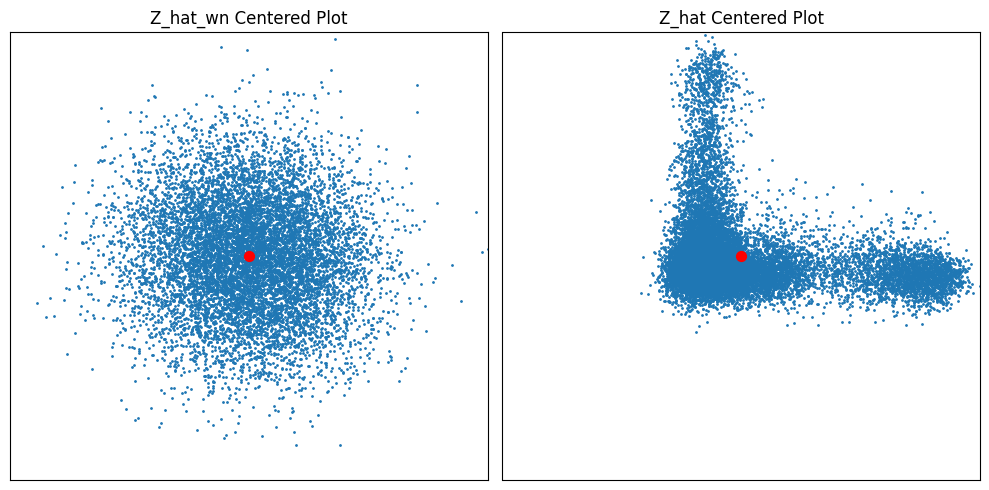

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Recenter Z_hat by subtracting the mean of columns 2 and 4
Z_hat_centered = Z_hat.copy()
Z_hat_centered[:, 2] = Z_hat[:, 2] - np.mean(Z_hat[:, 2])
Z_hat_centered[:, 4] = Z_hat[:, 4] - np.mean(Z_hat[:, 4])

# Recenter Z_hat_wn by subtracting the mean of columns 2 and 4
Z_hat_wn_centered = Z_hat_wn.copy()
Z_hat_wn_centered[:, 2] = Z_hat_wn[:, 2] - np.mean(Z_hat_wn[:, 2])
Z_hat_wn_centered[:, 3] = Z_hat_wn[:, 3] - np.mean(Z_hat_wn[:, 3])

# Helper function to set symmetric limits around zero
def set_symmetric_limits(data_x, data_y):
    max_x_range = max(abs(data_x.min()), abs(data_x.max()))
    max_y_range = max(abs(data_y.min()), abs(data_y.max()))
    max_range = max(max_x_range, max_y_range)
    return (-max_range, max_range), (-max_range, max_range)

# Create a figure and two subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# First scatter plot in the first subplot with centered data
ax[1].scatter(Z_hat_centered[:, 2], Z_hat_centered[:, 4], s=1)
ax[1].set_title("Z_hat Centered Plot")
ax[1].scatter(0, 0, color='red', s=50)  # Add red origin point

# Set symmetric limits for the first plot
x_lim, y_lim = set_symmetric_limits(Z_hat_centered[:, 2], Z_hat_centered[:, 4])
ax[1].set_xlim(x_lim)
ax[1].set_ylim(y_lim)

# Second scatter plot in the second subplot with centered data
ax[0].scatter(Z_hat_wn_centered[:, 2], Z_hat_wn_centered[:, 3], s=1)
ax[0].set_title("Z_hat_wn Centered Plot")
ax[0].scatter(0, 0, color='red', s=50)  # Add red origin point

# Set symmetric limits for the second plot
x_lim, y_lim = set_symmetric_limits(Z_hat_wn_centered[:, 2], Z_hat_wn_centered[:, 3])
ax[0].set_xlim(x_lim)
ax[0].set_ylim(y_lim)

# Remove axis values (tick labels) for both subplots
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[0].set_xticks([])
ax[0].set_yticks([])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined figure
plt.show()

In [27]:
Z_hat_wn.shape

(10000, 50)